In [20]:
# Import the libraries
import pandas as pd
import numpy as np

import os
import sys

# Librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

import csv
import pickle
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf

print ("Done")

Done


In [21]:
#Installing pydub for converting other sound format to wav format
!pip install pydub

In [22]:
#Import AudioSegment from pydub and isntalling librosa version based on gcp
from pydub import AudioSegment
!pip install librosa==0.10.1

# Importing Data

In [23]:
# Import and associate Google Drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cd '/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition'

/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition


In [28]:
# See content of working directory
!ls

dataset		  demo_audio	   main        model_weights.h5  scaler2.pickle
dataset_attr.csv  encoder2.pickle  model.json  nagham.csv	 trained_models


# Creating Path csv and Label

In [29]:
dataset_path = os.path.abspath('./dataset') #dataset directory from working directory
destination_path = os.path.abspath('./') #target for csv file

In [30]:
# creating label based on sub folder of dataset
flist = []
labels = set() # use set to prevent duplicate
for root, dirs, files in os.walk(dataset_path, topdown=True):
  for name in files:
    if (name.endswith('.wav')):
      fullName = os.path.join(root, name)
      flist.append(fullName)

split_format = str('/') if sys.platform=='linux' else str('\\')

filenames=[]
for idx,file in enumerate(flist):
  filenames.append(file.split(split_format))

for i in range(len(filenames)):
  labels.add(filenames[i][-2])

In [34]:
sorted_labels = sorted(labels) #sort the labels for consitent naming and index
labels

{'A.1_tausyih_bayati_ashli_qorror_ar-rahman',
 'A.2_tausyih_bayati_ashli_nawa_ar-rahman',
 'A.3_tausyih_bayati_syuri_1',
 'A.3_tausyih_bayati_syuri_2_ar-rahman',
 'A.3_tausyih_bayati_syuri_3',
 'A.4_tausyih_bayati_husaini_1',
 'A.4_tausyih_bayati_husaini_2_ar-rahman',
 'A.4_tausyih_bayati_husaini_3',
 'A.4_tausyih_bayati_husaini_4_ar-rahman',
 'A.4_tausyih_bayati_husaini_5',
 'A.4_tausyih_bayati_husaini_6',
 'A.5_tausyih_bayati_ashli_jawab_1_ar-rahman',
 'A.5_tausyih_bayati_ashli_jawab_2',
 'A.5_tausyih_bayati_ashli_jawab_3',
 'A.6_tausyih_bayati_syuri_jawabuljawab_ar-rahman',
 'B.1_tausyih_shaba_ashli_1_ar-rahman',
 'B.1_tausyih_shaba_ashli_2',
 'B.1_tausyih_shaba_ashli_3',
 'B.1_tausyih_shaba_ashli_4',
 'B.2_tausyih_jawab_shaba_ar-rahman',
 'B.3_tausyih_jawab_shaba_maalajam_ar-rahman',
 'B.4_tausyih_jawab_shaba_maalbastanjar_ar-rahman',
 'C.1_tausyih_hijaz_ashli_1',
 'C.1_tausyih_hijaz_ashli_2_ar-rahman',
 'C.1_tausyih_hijaz_ashli_3',
 'C.1_tausyih_hijaz_ashli_4',
 'C.1_tausyih_hijaz

In [35]:
labels = list(sorted_labels) #convert to list for manipulation

In [36]:
#to know total target of label
len(labels)

48

In [37]:
def create_meta_csv(dataset_path, destination_path, labels):

    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')):
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')

    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format))
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],labels.index(path[-2])))

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True

In [38]:
def create_and_load_meta_csv_df(dataset_path, destination_path, labels, randomize=True, split=None):

    if create_meta_csv(dataset_path, destination_path=destination_path, labels=labels):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))

    return dframe

In [39]:
df = create_and_load_meta_csv_df(dataset_path, destination_path, labels=labels) #create path and label csv file

In [40]:
df.head()

path  label
0  /content/drive/MyDrive/Colab Notebooks/Audio N...     40
1  /content/drive/MyDrive/Colab Notebooks/Audio N...     40
2  /content/drive/MyDrive/Colab Notebooks/Audio N...     40
3  /content/drive/MyDrive/Colab Notebooks/Audio N...     40
4  /content/drive/MyDrive/Colab Notebooks/Audio N...     40

# Data augmentation

In [41]:
# Noise
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretch
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

# Shift
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps =pitch_factor)

In [42]:
data, sr= librosa.load(df.path[0])

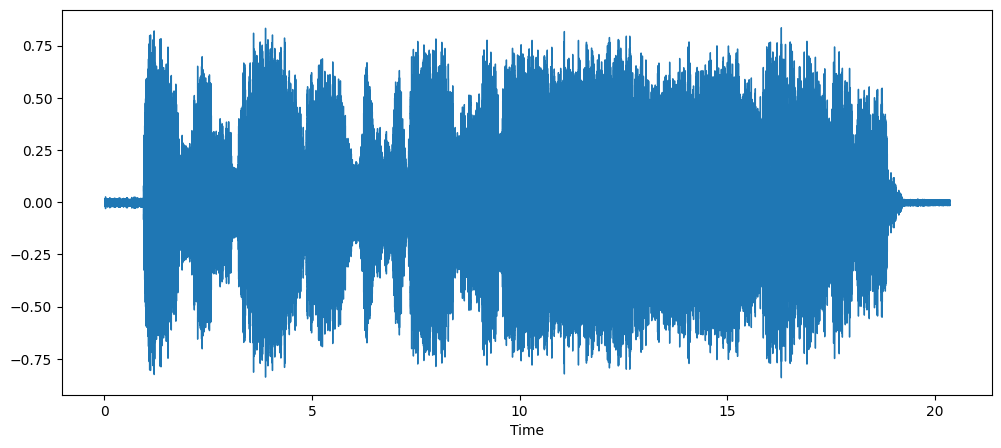

In [43]:
# Normal Audio
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

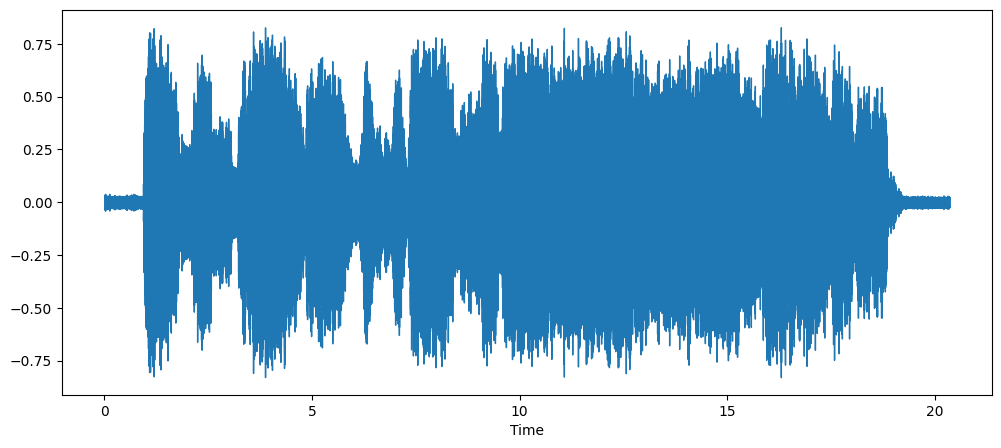

In [44]:
# Noised Audio
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

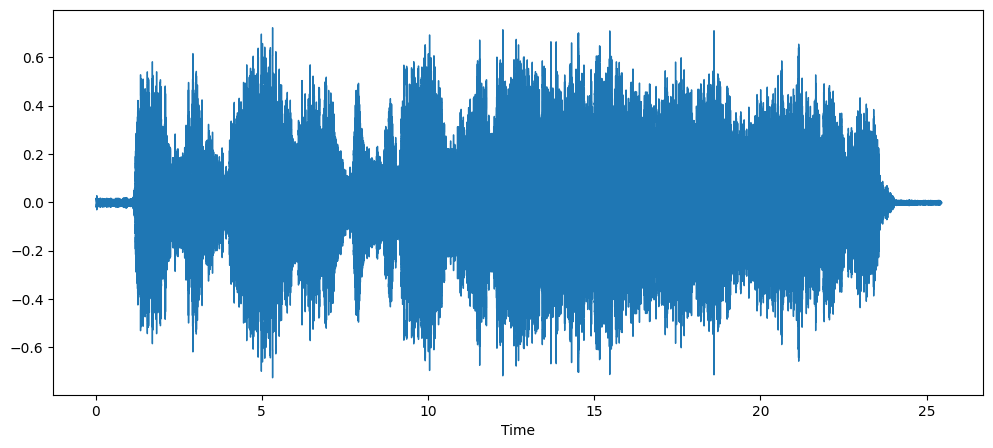

In [45]:
# Stretched Audio
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

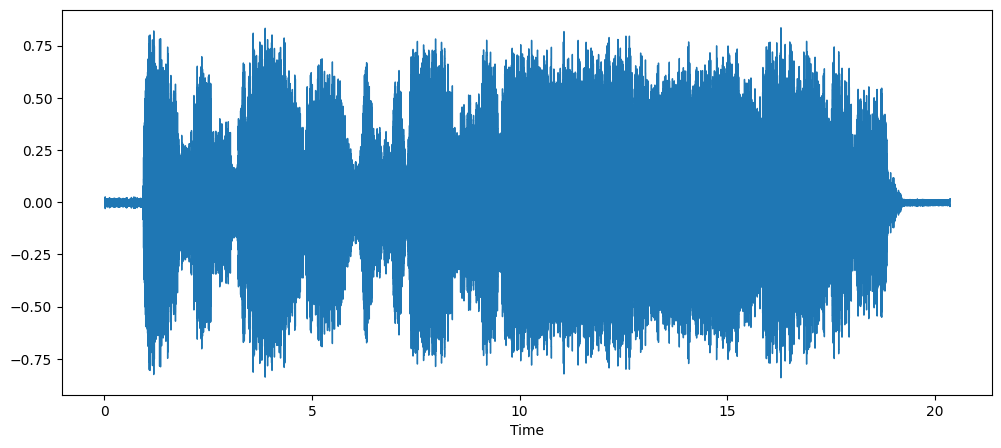

In [46]:
# Shifted Audio
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

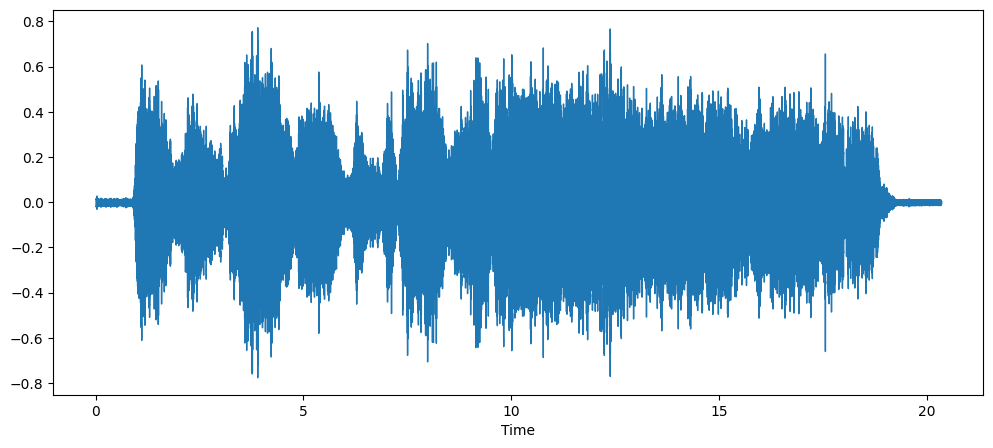

In [47]:
# Pithced Audio
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [48]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=35.0, offset=0.3):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [49]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Get Features

In [50]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,label in zip(df['path'],df['label']):
    features=get_features(path)
    for i in features:
        X.append(i)
        Y.append(label)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

Done
Time:  487.983589801


In [51]:
len(X), len(Y), df.path.shape

(1516, 1516, (379,))

# Saving features

In [52]:
Naghams = pd.DataFrame(X)
Naghams['Naghams'] = Y
Naghams.to_csv('nagham.csv', index=False)
Naghams.head()

0         1         2         3         4         5         6  \
0  0.001953  0.004883  0.005859  0.005859  0.003906  0.003906  0.002930   
1  0.211914  0.317871  0.416504  0.415039  0.415039  0.428711  0.439941   
2  0.000000  0.000000  0.000000  0.000000  0.000488  0.001953  0.001953   
3  0.216309  0.321289  0.428223  0.428711  0.423828  0.437012  0.443359   
4  0.003906  0.003906  0.005859  0.002930  0.002930  0.004883  0.005859   

          7         8         9  ...  33167  33168  33169  33170  33171  \
0  0.004883  0.004883  0.003906  ...    NaN    NaN    NaN    NaN    NaN   
1  0.428711  0.420410  0.402832  ...    NaN    NaN    NaN    NaN    NaN   
2  0.004883  0.004395  0.003906  ...    NaN    NaN    NaN    NaN    NaN   
3  0.438477  0.445801  0.432129  ...    NaN    NaN    NaN    NaN    NaN   
4  0.004883  0.007812  0.006836  ...    NaN    NaN    NaN    NaN    NaN   

   33172  33173  33174  33175  Naghams  
0    NaN    NaN    NaN    NaN       40  
1    NaN    NaN    NaN    NaN       40  
2    NaN    NaN    NaN    NaN       40  
3    NaN    NaN    NaN    NaN       40  
4    NaN    NaN    NaN    NaN       40  

[5 rows x 33177 columns]

# Preprocessing

In [53]:
Naghams = pd.read_csv('./nagham.csv')
Naghams.head()

0         1         2         3         4         5         6  \
0  0.001953  0.004883  0.005859  0.005859  0.003906  0.003906  0.002930   
1  0.211914  0.317871  0.416504  0.415039  0.415039  0.428711  0.439941   
2  0.000000  0.000000  0.000000  0.000000  0.000488  0.001953  0.001953   
3  0.216309  0.321289  0.428223  0.428711  0.423828  0.437012  0.443359   
4  0.003906  0.003906  0.005859  0.002930  0.002930  0.004883  0.005859   

          7         8         9  ...  33167  33168  33169  33170  33171  \
0  0.004883  0.004883  0.003906  ...    NaN    NaN    NaN    NaN    NaN   
1  0.428711  0.420410  0.402832  ...    NaN    NaN    NaN    NaN    NaN   
2  0.004883  0.004395  0.003906  ...    NaN    NaN    NaN    NaN    NaN   
3  0.438477  0.445801  0.432129  ...    NaN    NaN    NaN    NaN    NaN   
4  0.004883  0.007812  0.006836  ...    NaN    NaN    NaN    NaN    NaN   

   33172  33173  33174  33175  Naghams  
0    NaN    NaN    NaN    NaN       40  
1    NaN    NaN    NaN    NaN       40  
2    NaN    NaN    NaN    NaN       40  
3    NaN    NaN    NaN    NaN       40  
4    NaN    NaN    NaN    NaN       40  

[5 rows x 33177 columns]

In [54]:
print(Naghams.isna().any())

0          False
1          False
2          False
3          False
4          False
           ...  
33172       True
33173       True
33174       True
33175       True
Naghams    False
Length: 33177, dtype: bool


In [55]:
Naghams=Naghams.fillna(0)
print(Naghams.isna().any())
Naghams.shape

0          False
1          False
2          False
3          False
4          False
           ...  
33172      False
33173      False
33174      False
33175      False
Naghams    False
Length: 33177, dtype: bool


(1516, 33177)

In [56]:
np.sum(Naghams.isna())

0          0
1          0
2          0
3          0
4          0
          ..
33172      0
33173      0
33174      0
33175      0
Naghams    0
Length: 33177, dtype: int64

# Data preparation

In [57]:
# Retrieves all rows and all columns except the last column for X, which contains the features
X = Naghams.iloc[:, :-1].values

# Take the last column for Y, which contains emotions
Y = Naghams['Naghams'].values

In [58]:
# As this is a multiclass classification problem one hot encoding the Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [59]:
print(Y.shape)
X.shape

(1516, 48)


(1516, 33176)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1212, 33176), (1212, 48), (304, 33176), (304, 48))

In [61]:
# reshape data
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [62]:
# reshape data to CNN model
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((1212, 33176, 1), (1212, 48), (304, 33176, 1), (304, 48))

In [63]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1212, 33176), (1212, 48), (304, 33176), (304, 48))

# Modeling

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(256, 5, padding='same', input_shape=(x_traincnn.shape[1],x_traincnn.shape[2]), activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1],activation='softmax')
])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33176, 256)        1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16588, 256)        0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16588, 128)        163968    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8294, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8294, 128)         82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4147, 128)         0

In [66]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [67]:
history=model.fit(x_traincnn, y_train, epochs=7, validation_data=(x_testcnn, y_test), batch_size=16)

Epoch 1/7
76/76 [==============================] - 25s 229ms/step - loss: 10.5318 - accuracy: 0.4464 - val_loss: 0.5687 - val_accuracy: 0.8651
Epoch 2/7
76/76 [==============================] - 15s 200ms/step - loss: 0.1264 - accuracy: 0.9703 - val_loss: 0.1741 - val_accuracy: 0.9737
Epoch 3/7
76/76 [==============================] - 15s 201ms/step - loss: 0.0112 - accuracy: 0.9983 - val_loss: 0.1461 - val_accuracy: 0.9836
Epoch 4/7
76/76 [==============================] - 15s 203ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1531 - val_accuracy: 0.9836
Epoch 5/7
76/76 [==============================] - 15s 204ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1643 - val_accuracy: 0.9836
Epoch 6/7
76/76 [==============================] - 16s 205ms/step - loss: 6.6609e-04 - accuracy: 1.0000 - val_loss: 0.1713 - val_accuracy: 0.9836
Epoch 7/7
76/76 [==============================] - 16s 206ms/step - loss: 5.0509e-04 - accuracy: 1.0000 - val_loss: 0.1805 - val_accuracy: 0.98

10/10 [==============================] - 3s 131ms/step - loss: 0.1805 - accuracy: 0.9836
Accuracy of our model on test data :  98.3552634716034 %


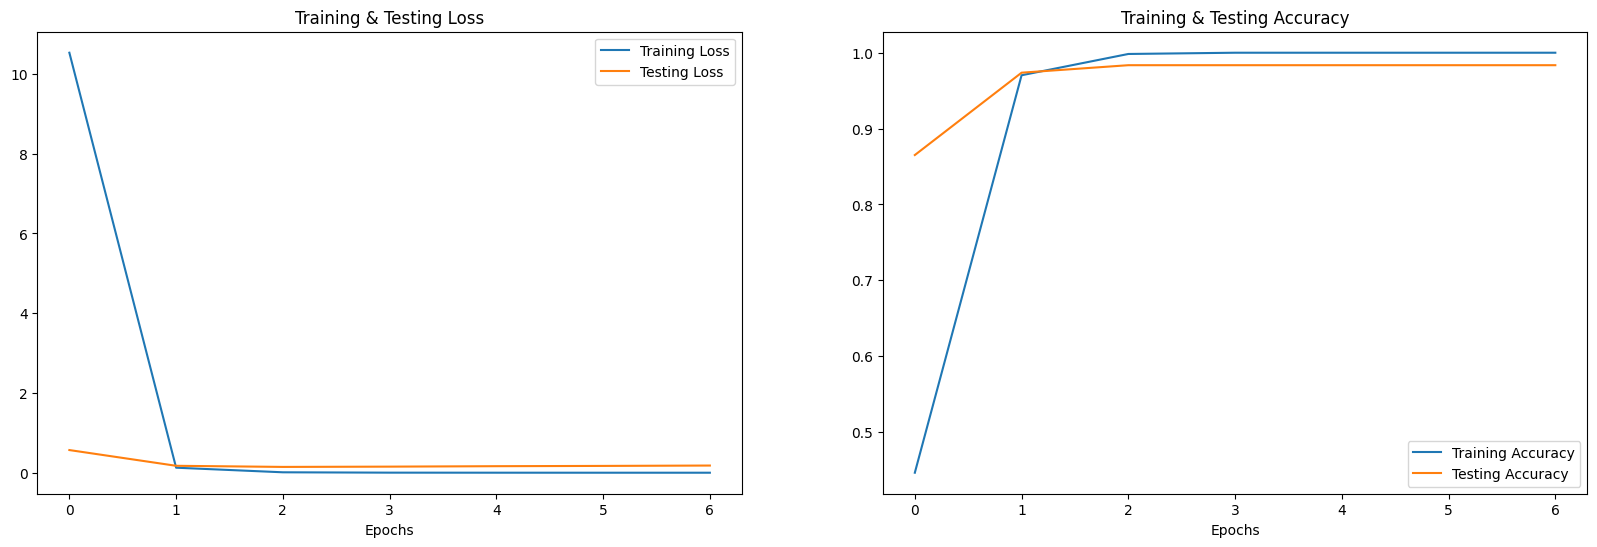

In [68]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(7)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [69]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

10/10 [==============================] - 1s 137ms/step


Predicted Labels  Actual Labels
0                43             43
1                44             44
2                 3              3
3                17             17
4                36             36
5                15             15
6                31             31
7                45             45
8                 3              3
9                 3              3

In [70]:
df0

Predicted Labels  Actual Labels
0                  43             43
1                  44             44
2                   3              3
3                  17             17
4                  36             36
..                ...            ...
299                47             47
300                 1              1
301                22             22
302                 8              8
303                21             21

[304 rows x 2 columns]

Some plots of multi_model
______________________________________________


# Saving Model

In [71]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [72]:
json_file = open(os.path.join(os.getcwd(), '/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(os.getcwd(), '/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model_weights.h5'))
print("Loaded model from disk")

Loaded model from disk


In [73]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

10/10 [==============================] - 2s 131ms/step - loss: 0.1805 - accuracy: 0.9836
accuracy: 98.36%


# Saving and Loading our Stnadrad Scaler and encoder

pickle file


In [75]:
import pickle

# Saving scaler
with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


# Deploying Model

In [76]:
X.shape[1]

33176

In [77]:
json_file = open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [78]:
with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/trained_models/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


In [79]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [80]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=35.0, offset=0.3)
    res=extract_features(d)
    result=np.array(res)
    target_shape = (1,X.shape[1])
    zeroes_array = np.zeros(target_shape)
    zeroes_array[0, :result.size] = result
    i_result = scaler2.transform(zeroes_array)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [81]:
#Dictionary for prediction result
category_naghams={

          # Bayati ashli qorror
          1:'A.1_tausyih_bayati_ashli_qorror_ar-rahman',
          # Bayati ashli nawa
          2:'A.2_tausyih_bayati_ashli_nawa_ar-rahman',
          # Bayati syuti
          3:'A.3_tausyih_bayati_syuri_1',                         4:'A.3_tausyih_bayati_syuri_2_ar-rahman',           5:'A.3_tausyih_bayati_syuri_3',
          # Bayati husaini
          6:'A.4_tausyih_bayati_husaini_1',                       7:'A.4_tausyih_bayati_husaini_2_ar-rahman',
          8:'A.4_tausyih_bayati_husaini_3',                       9:'A.4_tausyih_bayati_husaini_4_ar-rahman',         10:'A.4_tausyih_bayati_husaini_5',
          11:'A.4_tausyih_bayati_husaini_6',
          # Bayati ashli jawab
          12:'A.5_tausyih_bayati_ashli_jawab_1_ar-rahman',        13:'A.5_tausyih_bayati_ashli_jawab_2',              14:'A.5_tausyih_bayati_ashli_jawab_3',
          # Bayati syuri jawabuljawab
          15:'A.6_tausyih_bayati_syuri_jawabuljawab_ar-rahman',   47:'a1.6_ar-rahman_bayati_syuri_jawabuljawab_2',

          # Shaba ashli
          16:'B.1_tausyih_shaba_ashli_1_ar-rahman',               17:'B.1_tausyih_shaba_ashli_2',                     18:'B.1_tausyih_shaba_ashli_3',
          19:'B.1_tausyih_shaba_ashli_4',
          # Jawab shaba
          20:'B.2_tausyih_jawab_shaba_ar-rahman',
          # Jawab shaba maalajam
          21:'B.3_tausyih_jawab_shaba_maalajam_ar-rahman',
          # Jawab shaba maalbastanjar
          22:'B.4_tausyih_jawab_shaba_maalbastanjar_ar-rahman',

          # Hijaz ashli
          23:'C.1_tausyih_hijaz_ashli_1',                         24:'C.1_tausyih_hijaz_ashli_2_ar-rahman',           25:'C.1_tausyih_hijaz_ashli_3',
          26:'C.1_tausyih_hijaz_ashli_4',                         27:'C.1_tausyih_hijaz_ashli_5',                     28:'C.1_tausyih_hijaz_ashli_6',
          # Hijaz kar
          29:'C.2_tausyih_hijaz_kar_ar-rahman',
          # Hijaz karkur
          30:'C.3_tausyih_hijaz_karkur',
          # Hijaz kur
          31:'C.4_tausyih_hijaz_kur',

          # Rast ashli
          32:'D.1_tausyih_rast_ashli_1',                          33:'D.1_tausyih_rast_ashli_2_ar-rahman',            34:'D.1_tausyih_rast_ashli_3',
          35:'D.1_tausyih_rast_ashli_4_ar-rahman',
          # Rast alanawa
          36:'D.2_tausyih_rast_alanawa_2_ar-rahman',              37:'D.2_tausyih_rast_alanawa_4',                    38:'D.2_tausyih_rast_alanawa_5_ar-rahman',
          # Rast zunjiran
          48:'d1.2_ar-rahman_rast_zunjiran',

          # Sika ashli
          39:'E.1_tausyih_sika_ashli_ar-rahman',
          # Sika turki
          40:'E.2_tausyih_sika_turki_ar-rahman',
          # Sika mishri
          41:'E.3_tausyih_sika_mishri_ar-rahman',

          # Jiharkah ashli
          42:'F.1_tausyih_jiharkah_ashli_ar-rahman',
          # Jiharkah jawab
          43:'F.2_tausyih_jiharkah_jawab',                        44:'F.2_tausyih_jiharkah_jawab_2_ar-rahman',

          # Nahawand ashli
          45:'G.1_tausyih_nahawand_ashli_ar-rahman',
          # Nahawand jawab
          46:'G.2_tausyih_nahawand_jawab_ar-rahman'

          }

In [82]:
def fix_and_predict(file_path):
    # Fix the WAV file
    fixed_file_path = fix_wav(file_path)
    # Get prediction features
    res = get_predict_feat(fixed_file_path)
    # Make predictions
    predictions = loaded_model.predict(res)
    # Get the predicted nagham label
    nagham_index = np.argmax(predictions[0])
    nagham_label = category_naghams[nagham_index + 1]
    print("Predicted:", nagham_label)

In [83]:
def fix_wav(file_path):
    audio = AudioSegment.from_file(file_path)
    fixed_file_path = file_path
    audio.export(fixed_file_path, format="wav")
    return fixed_file_path

In [85]:
# Example usage
file_path = '/content/drive/MyDrive/Colab Notebooks/Audio Nagham Recognition/dataset/A.1_tausyih_bayati_ashli_qorror_ar-rahman/1.0_ar-rahman_bayyati_ashli_qorror_v1_b.wav'
fix_and_predict(file_path)

1/1 [==============================] - 0s 459ms/step
Predicted: A.4_tausyih_bayati_husaini_2_ar-rahman
